In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read data from CSV file
df = pd.read_csv('train.csv', parse_dates=['date'])

# Set 'date' as the index
df.set_index('date', inplace=True)


In [2]:
def detect_anomalies_for_sensor(sensor_data, threshold=3):
    # Calculate the mean and standard deviation for the sensor data
    mean = sensor_data.mean()
    std = sensor_data.std()

    # Calculate the z-score for the sensor data
    z_scores = (sensor_data - mean) / std

    # Identify anomalies (data points with z-score greater than threshold)
    anomalies = np.abs(z_scores) > threshold

    return anomalies

# Set the threshold for anomaly detection (you can adjust this based on your data)
threshold = 4.5

In [3]:
# Initialize an empty DataFrame to store anomalies
anomalies_df = pd.DataFrame(index=df.index)

# Detect anomalies for each sensor
for sensor in ['temperature', 'light', 'airHumidity', 'humidity']:
    sensor_data = df[sensor]
    anomalies = detect_anomalies_for_sensor(sensor_data, threshold=threshold)
    anomalies_df[sensor + '_anomaly'] = anomalies

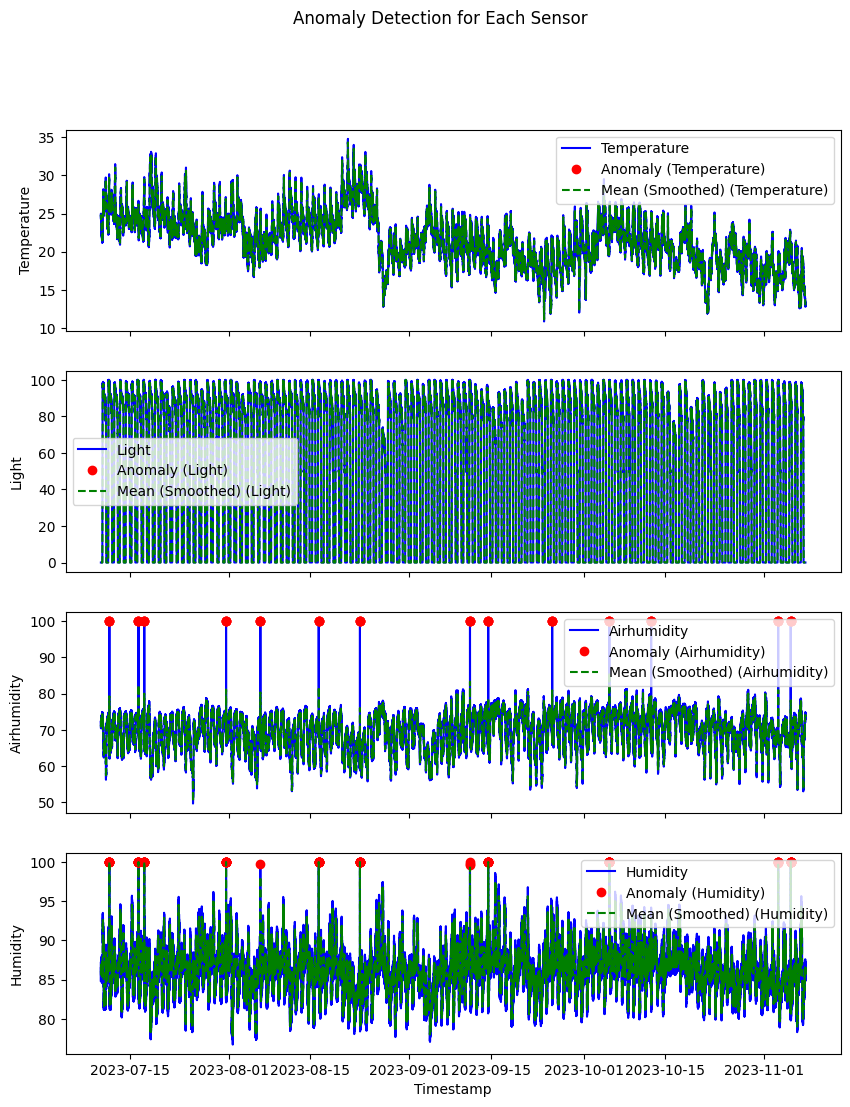

In [4]:
# Plot each sensor in a separate subplot
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 12), sharex=True)

# Function to plot anomalies with a curve for each sensor
def plot_anomalies_with_curve(ax, x, y, anomalies, color, label):
    ax.plot(x, y, label=label, color=color)
    ax.plot(x[anomalies], y[anomalies], color='red', linestyle='None', marker='o', label=f'Anomaly ({label})')
    ax.plot(x, y.rolling(window=10).mean(), color='green', linestyle='--', label=f'Mean (Smoothed) ({label})')

# Plot anomalies for each sensor
for i, sensor in enumerate(['temperature', 'light', 'airHumidity', 'humidity']):
    sensor_anomalies = anomalies_df[sensor + '_anomaly']
    plot_anomalies_with_curve(axes[i], df.index, df[sensor], sensor_anomalies, 'blue', sensor.capitalize())
    axes[i].set_ylabel(sensor.capitalize())
    axes[i].legend()

plt.xlabel('Timestamp')
plt.suptitle('Anomaly Detection for Each Sensor')
plt.show()

In [5]:
def clean_anomalies(df, threshold=4.5):
    cleaned_df = df.copy()

    columns = ['temperature', 'light', 'airHumidity', 'humidity']

    for sensor in columns:
        sensor_data = df[sensor]
        anomalies = detect_anomalies_for_sensor(sensor_data, threshold=threshold)

        # Calculate the rolling mean for smoothing
        smoothed_data = sensor_data.rolling(window=10).mean()

        # Replace anomalies with smoothed values
        cleaned_df[sensor + '_cleaned'] = cleaned_df[sensor].copy()
        cleaned_df[sensor + '_cleaned'][anomalies] = smoothed_data[anomalies]

    cleaned_df.drop(columns=columns, inplace=True)

    return cleaned_df
cleaned_df = clean_anomalies(df, threshold=threshold)

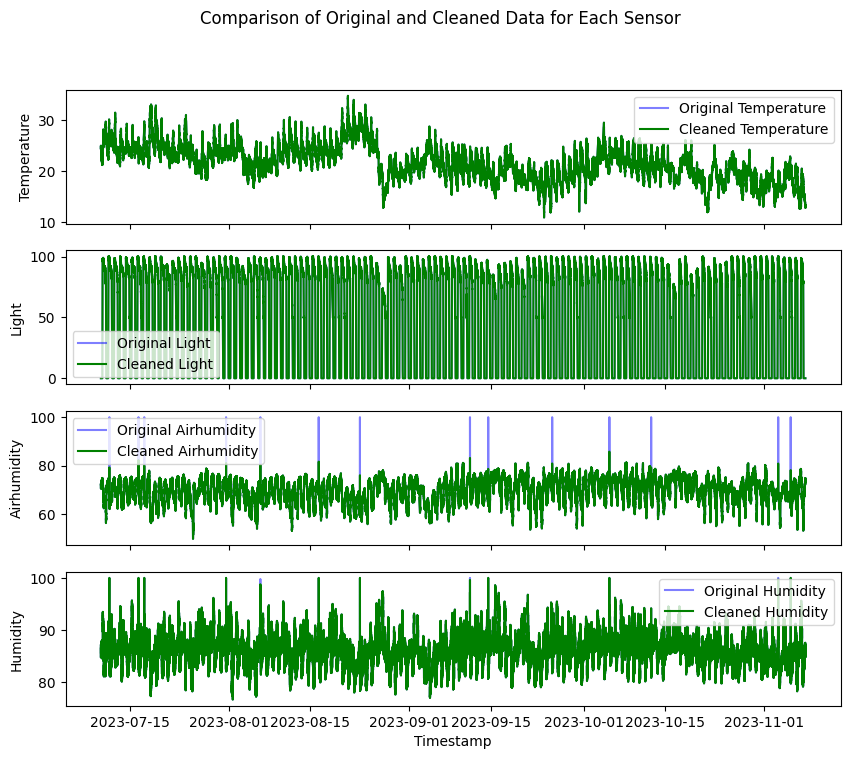

In [6]:
# Plot original and cleaned data for each sensor
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 8), sharex=True)

# Function to plot original and cleaned data for each sensor
def plot_original_and_cleaned_data(ax, x, original_data, cleaned_data, color_original, color_cleaned, label):
    ax.plot(x, original_data, label=f'Original {label}', color=color_original, alpha=0.5)
    ax.plot(x, cleaned_data, label=f'Cleaned {label}', color=color_cleaned)

# Plot original and cleaned data for each sensor
for i, sensor in enumerate(['temperature', 'light', 'airHumidity', 'humidity']):
    original_sensor_data = df[sensor]
    cleaned_sensor_data = cleaned_df[sensor + '_cleaned']
    plot_original_and_cleaned_data(axes[i], df.index, original_sensor_data, cleaned_sensor_data, 'blue', 'green', sensor.capitalize())
    axes[i].set_ylabel(sensor.capitalize())
    axes[i].legend()

plt.xlabel('Timestamp')
plt.suptitle('Comparison of Original and Cleaned Data for Each Sensor')
plt.show()

In [7]:
cleaned_df.to_csv('unidad_verdejante-anomaly.csv')